In [1]:
using NLsolve, Plots, Distributions, StatsPlots

struct Calibration
    σ::Float64           # elasticity of relative demand with respect to price         
    γ::Vector{Float64}   # intensity in each good
    ϵ::Vector{Float64}   # elasticity of relative demand with respect to income in luxury good sector
    κ::Vector{Float64}   # For Stone and Geary
    g::Vector{Float64}
end

cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.6, 1.0, 1.65],       #ELASTICITIES
    [0.05, 0.03, 0.02],     #For Stone and Geary
    [1.05, 1.02, 1.01]      # price dynamics
)

ρ=(cal.σ-1)/cal.σ

-1.0

In [2]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(cal.γ[i]^(1/cal.σ)*(((p[i]/E)^(-cal.σ)*cal.γ[i])/u^((1-cal.σ)*cal.σ*cal.ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(cal.γ[i]*U^(cal.ϵ[i]*cal.σ*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    return [C1, C2, C3, U]#, U, E, ω]

end

NHUtility (generic function with 1 method)

In [167]:
function GEprices(Endow::Vector{Any}, p::Vector{Float64} ; cal=cal, tol=1e-1)
    ng=3                    #nber of good
    na=10.0                 #max unit for one good type
    W=zeros(ng)             #Endowment
    D=zeros(ng)             #NH Demand
    Excess=zeros(ng)
    pricepath=[]
    #First value for excess, 
    #1. if D>W Price increases
    #2. if D<W Price drops
    for i=1:ng
        W[i]=sum(Endow[j,:][1][i] for j=1:length(Endow))
        D[i]=sum(NHUtility(Endow[j,:][1],p)[i] for j=1:length(Endow))
    end

    Excess= D-W

    for j=1:ng
        while abs(Excess[j])>tol
            pricepath=push!(pricepath,[p[1], p[2], p[3]])

            for i=1:ng
                p[i]=p[i]+0.001*Excess[i]
                W[i]=sum(Endow[j,:][1][i] for j=1:length(Endow))
                D[i]=sum(NHUtility(Endow[j,:][1],p)[i] for j=1:length(Endow))
            end
            Excess=D-W
        end
    end
        
    return pricepath
end

GEprices (generic function with 1 method)

In [181]:
#Prices and Endowment vector for everyone 
p=[4.0, 6.0, 10.0]
Endow=[]
sca=10.0
for i = 1:sca
    for j=1:sca
        for k =1:sca
            Endow=push!(Endow, [i, j, k])
        end
    end
end
Endow

1000-element Vector{Any}:
 [1.0, 1.0, 1.0]
 [1.0, 1.0, 2.0]
 [1.0, 1.0, 3.0]
 [1.0, 1.0, 4.0]
 [1.0, 1.0, 5.0]
 [1.0, 1.0, 6.0]
 [1.0, 1.0, 7.0]
 [1.0, 1.0, 8.0]
 [1.0, 1.0, 9.0]
 [1.0, 1.0, 10.0]
 ⋮
 [10.0, 10.0, 2.0]
 [10.0, 10.0, 3.0]
 [10.0, 10.0, 4.0]
 [10.0, 10.0, 5.0]
 [10.0, 10.0, 6.0]
 [10.0, 10.0, 7.0]
 [10.0, 10.0, 8.0]
 [10.0, 10.0, 9.0]
 [10.0, 10.0, 10.0]

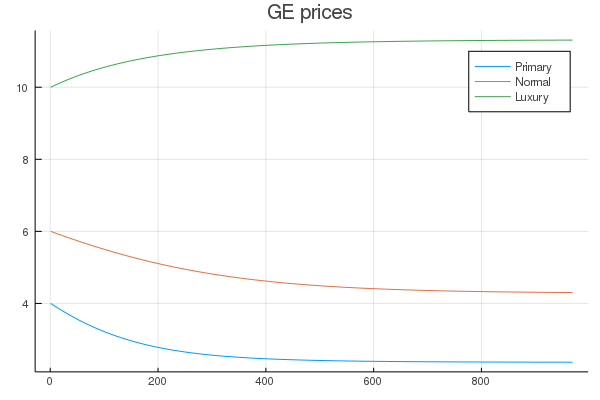

In [176]:
pricep=GEprices(Endow,p)
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices 27 agents", label=["Primary" "Normal" "Luxury"])

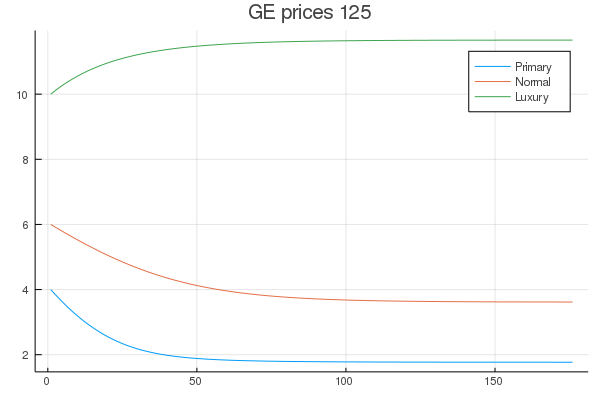

In [178]:
pricep=GEprices(Endow,p)
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices 125", label=["Primary" "Normal" "Luxury"])

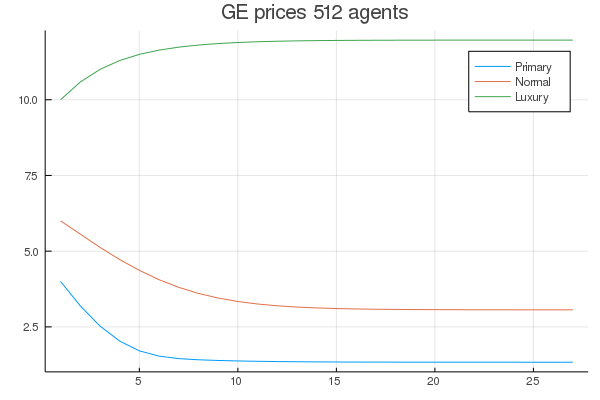

In [180]:
pricep=GEprices(Endow,p)
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices 512 agents", label=["Primary" "Normal" "Luxury"])

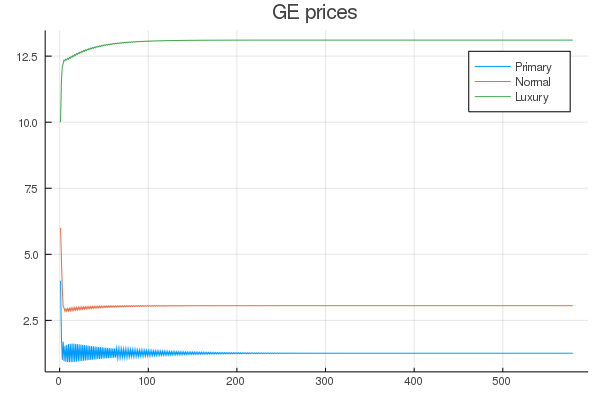

In [182]:
pricep=GEprices(Endow,p)
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices", label=["Primary" "Normal" "Luxury"])

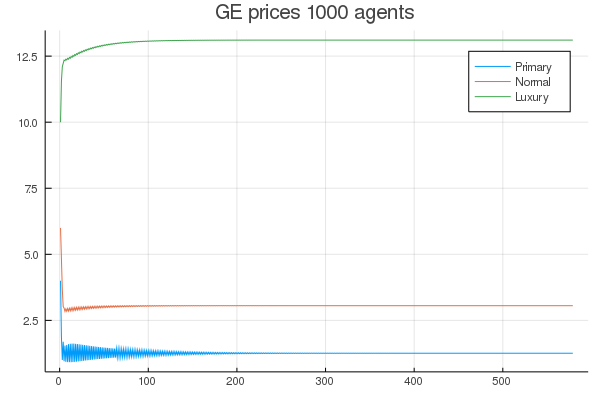

In [183]:
plot([p_p p_n p_l], title="GE prices 1000 agents", label=["Primary" "Normal" "Luxury"])

In this example, prices were first given at p=[10.0, 2.0, 4.0].
However, this price level does not clear the market, we have demand that takes over endowment level in our economy

In [185]:
ng, na

(3, 10)

In [205]:
G=zeros(ng,na)
for i =1:ng
    for j=1:na
        G[i,j]=rand(1:10)
    end
end

G

3×10 Matrix{Float64}:
  5.0  1.0   3.0  9.0  4.0  2.0  8.0  10.0  6.0  3.0
 10.0  2.0   6.0  3.0  9.0  8.0  1.0   9.0  4.0  1.0
  6.0  3.0  10.0  5.0  4.0  5.0  8.0   5.0  7.0  4.0

In [192]:
G[2]

4.0

In [206]:
function GEpricesincomerand(G::Matrix{Float64}, p::Vector{Float64} ; cal=cal, tol=1e-1)
    G=transpose(G)
    ng=3                    #nber of good
    na=10.0                 #max unit for one good type
    W=zeros(ng)             #Endowment
    D=zeros(ng)             #NH Demand
    Excess=zeros(ng)
    pricepath=[]
    #First value for excess, 
    #1. if D>W Price increases
    #2. if D<W Price drops
    for i=1:ng
        W[i]=sum(G[j,i] for j=1:length(na))
        D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:length(na))
    end

    Excess= D-W

    for j=1:ng
        while abs(Excess[j])>tol
            pricepath=push!(pricepath,[p[1], p[2], p[3]])

            for i=1:ng
                p[i]=p[i]+0.001*Excess[i]
                W[i]=sum(G[j,i] for j=1:length(na))
                D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:length(na))
            end
            Excess=D-W
        end
    end
        
    return pricepath
end

GEpricesincomerand (generic function with 1 method)

In [212]:

p=[4.0, 6.0, 10.0]


3-element Vector{Float64}:
  4.0
  6.0
 10.0

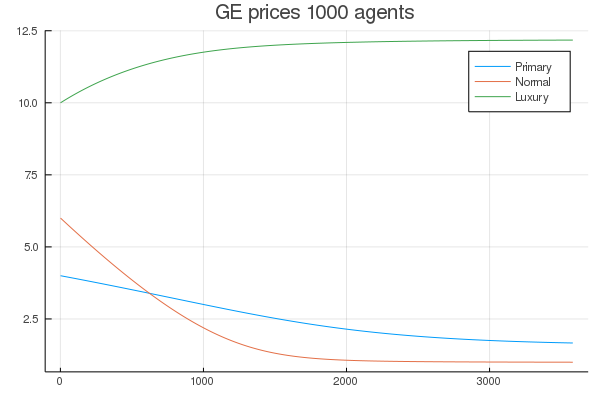

In [213]:
pricep=GEpricesincomerand(G,p)
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end
plot([p_p p_n p_l], title="GE prices 1000 agents", label=["Primary" "Normal" "Luxury"])